In [1]:
# imports for array-handling and plotting
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

# let's keep our keras backend tensorflow quiet
import os
# for testing on GPU
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
# for testing on CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

# keras imports for the dataset and building our neural network
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
#Ora dividiamo i dati MNIST in train e test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Il dataset di MNIST contiene solo immagini in grayscale

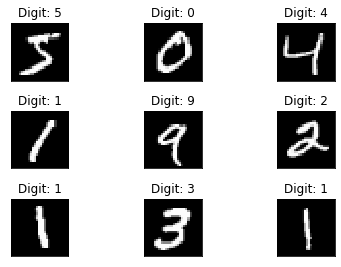

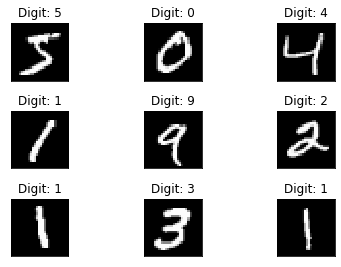

In [3]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig


Per addestrare la rete neurale, trasformiamo queste immagini 28*28 in un unico vettore monodimensionale da 784 

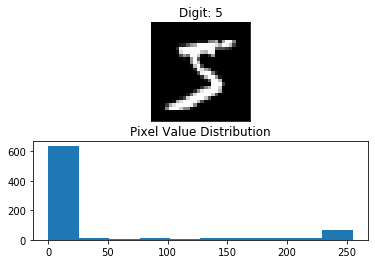

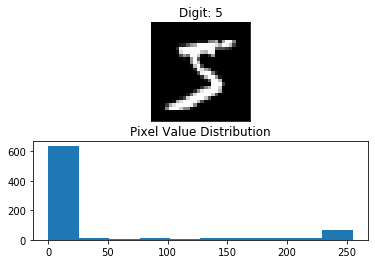

In [4]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(X_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train[0].reshape(784))
plt.title("Pixel Value Distribution")
fig

Ora normalizziamo il dataset per velocizzare il training. Così riduciamo la possibilità di bloccarci in ottimi locali (e quindi non globali), poiché stiamo usando la discesa gradiente stocastica per trovare i pesi ottimali per la rete.
Rimodelliamo i nostri input in un singolo vettore vettoriale e normalizziamo i valori dei pixel tra 0 e 1.

In [5]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


In [6]:
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


Codifichiamo le nostre categorie - cifre da 0 a 9 - usando la codifica one-hot. Il risultato è un vettore con una lunghezza uguale al numero di categorie. Il vettore è tutti zero tranne nella posizione per la rispettiva categoria. Quindi un '5' sarà rappresentato da [0,0,0,0,1,0,0,0,0].

In [7]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


# Costruiamo la Rete

Il nostro vettore di pixel sarà il nostro input.Per questa architettura di rete possiamo usare il modello sequenziale di Keras, e aggiungere i livelli tramite la add().

Per risolvere adeguatamente questo problema, creeremo 2 livelli da 512 nodi ciasciuno.
Per la classificazione multi-classe aggiungiamo, ad ogni livello, un altro layer densamente connesso (o completamente connesso) per le 10 diverse classi di output.

Oss.: quando si aggiunge il primo livello nel modello sequenziale, è necessario specificare la forma di input in modo che Keras possa creare le matrici appropriate. Per tutti i livelli rimanenti la forma viene dedotta automaticamente.

Per introdurre non linearità nella rete ed elevarla oltre le capacità di un semplice percettrone, aggiungiamo anche funzioni di attivazione agli strati nascosti. La differenziazione per l'allenamento tramite backpropagation sta avvenendo dietro le quinte senza dover implementare i dettagli.

Aggiungiamo anche il dropout come modo per prevenire un eccesso di adattamento. Qui manteniamo casualmente alcuni pesi di rete fissi quando normalmente li aggiorniamo in modo che la rete non faccia troppo affidamento su pochissimi nodi.

L'ultimo strato è costituito da connessioni per le nostre 10 classi e l'attivazione di softmax che è standard per target multi-classe.

In [8]:
# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

#Compiling and Training the Model

Ora che il modello è attivo, configuriamo il processo di apprendimento usando compile() . Qui specifichiamo la nostra funzione di perdita (o funzione oggettiva). Per come lo abbiamo impostato, l'entropia incrociata categorica si adatta al conto, ma in generale sono disponibili altre funzioni di perdita.

Per quanto riguarda l'ottimizzatore di scelta useremo Adam con le impostazioni predefinite. Potremmo anche creare un'istanza di un ottimizzatore e impostare i parametri prima di passarlo a model.compile(), ma per questo esempio le impostazioni predefinite vanno bene

Scegliamo anche quali metriche verranno valutate durante l'addestramento e i test. Siamo in grado di passare qualsiasi elenco di metriche (anche metriche costruite da noi stessi) e mostrarle durante il train/test, ma per ora alla metrica predefinita "accuracy".

In [9]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Dopo aver compilato il nostro modello, ora possiamo iniziare il processo di formazione. Dobbiamo specificare quante volte vogliamo iterare sull'intero set di addestramento (epoche) e quanti campioni utilizziamo per un aggiornamento dei pesi del modello (dimensione del lotto). Generalmente più grande è il batch, più stabili saranno i nostri aggiornamenti stocastici di discesa del gradiente. Ma bisogna fare attenzione ai limiti di memoria della GPU! Ora abbiamo impostato una dimensione del lotto di 128 e 20 epoche.

Per capire i progressi della nostra formazione, tracciamo anche la curva di apprendimento del nostro modello, osservando la perdita e l'accuratezza.

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 13s - loss: 0.2494 - accuracy: 0.9250 - val_loss: 0.1074 - val_accuracy: 0.9662
Epoch 2/20
 - 11s - loss: 0.0990 - accuracy: 0.9694 - val_loss: 0.0745 - val_accuracy: 0.9773
Epoch 3/20
 - 13s - loss: 0.0703 - accuracy: 0.9779 - val_loss: 0.0757 - val_accuracy: 0.9752
Epoch 4/20
 - 13s - loss: 0.0540 - accuracy: 0.9830 - val_loss: 0.0707 - val_accuracy: 0.9789
Epoch 5/20
 - 10s - loss: 0.0449 - accuracy: 0.9855 - val_loss: 0.0692 - val_accuracy: 0.9790
Epoch 6/20
 - 13s - loss: 0.0390 - accuracy: 0.9869 - val_loss: 0.0639 - val_accuracy: 0.9823
Epoch 7/20
 - 14s - loss: 0.0343 - accuracy: 0.9888 - val_loss: 0.0653 - val_accuracy: 0.9822
Epoch 8/20
 - 10s - loss: 0.0306 - accuracy: 0.9893 - val_loss: 0.0646 - val_accuracy: 0.9813
Epoch 9/20
 - 10s - loss: 0.0271 - accuracy: 0.9908 - val_loss: 0.0701 - val_accuracy: 0.9817
Epoch 10/20
 - 11s - loss: 0.0277 - accuracy: 0.9906 - val_loss: 0.0657 - val_accuracy: 0.9831
Epoch 11/

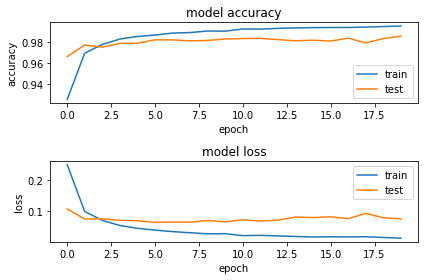

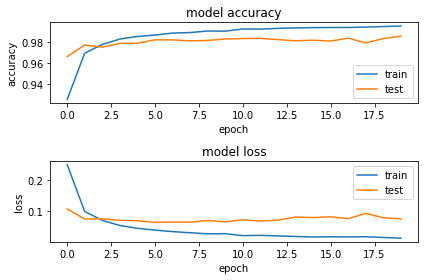

In [10]:
# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=20,
          verbose=2,
          validation_data=(X_test, Y_test))

# saving the model
save_dir = "results/"
model_name = 'TestHW5.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

Per come abbiamo impostato il problema, la curva di apprendimento sembra abbastanza buona. Possiamo vedere infatti come la perdita sul set di allenamento diminuisca rapidamente per le prime due epoche. Questo dimostra che la rete sta imparando a classificare le cifre abbastanza velocemente. Per il set di test la perdita non diminuisce rapidamente ma rimane all'incirca nello stesso intervallo della perdita di allenamento. Ciò significa che il nostro modello si generalizza bene ai dati invisibili.

#Evaluate the Model's Performance

È tempo di raccogliere i frutti della nostra formazione della rete neurale. Vediamo quanto bene il modello esegue sul set di test. Il metodo model.evaluate() calcola la perdita e qualsiasi metrica definita durante la compilazione del modello. Quindi nel nostro caso l'accuratezza viene calcolata sui 10.000 esempi di test utilizzando i pesi di rete forniti dal modello salvato.

In [11]:
mnist_model = load_model('results/TestHW5.h5')
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

Test Loss 0.07533862991010687
Test Accuracy 0.98580002784729


Ne è risultato che l'accuratezza sembra molto buona.
Valutiamo ora degli esempi classificati correttamente e degli esempi classificati in modo errato. Vedremo 9 esempi ciascuno.


9858  classified correctly
142  classified incorrectly


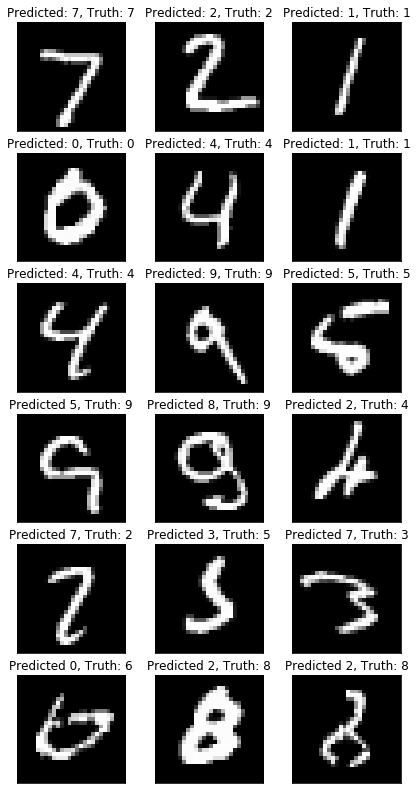

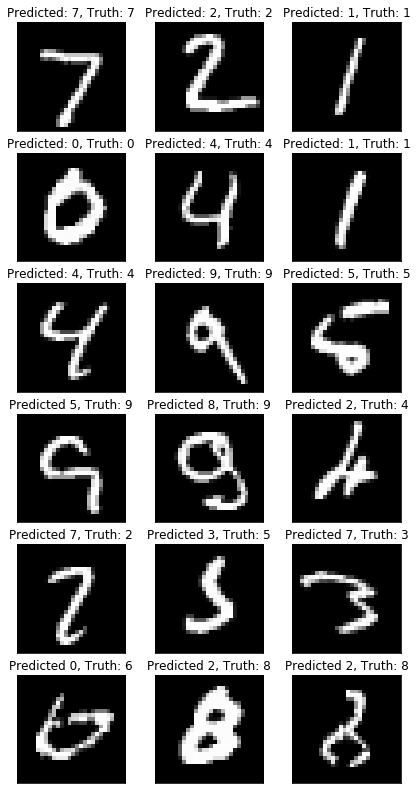

In [12]:
# load the model and create predictions on the test set
mnist_model = load_model('results/TestHW5.h5')
predicted_classes = mnist_model.predict_classes(X_test)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])
    
# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

figure_evaluation